# 1. Imports

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip '/content/drive/My Drive/loader_util.zip'

Archive:  /content/drive/My Drive/loader_util.zip
   creating: loader_util/
   creating: loader_util/callbacks/
  inflating: loader_util/callbacks/epochcheckpoint.py  
  inflating: loader_util/callbacks/trainingmonitor.py  
  inflating: loader_util/callbacks/__init__.py  
   creating: loader_util/callbacks/__pycache__/
  inflating: loader_util/callbacks/__pycache__/epochcheckpoint.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/trainingmonitor.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/__init__.cpython-36.pyc  
   creating: loader_util/datasets/
  inflating: loader_util/datasets/simpledatasetloader.py  
  inflating: loader_util/datasets/torch_dataset_loader.py  
  inflating: loader_util/datasets/torch_train_test_split.py  
  inflating: loader_util/datasets/__init__.py  
   creating: loader_util/datasets/__pycache__/
  inflating: loader_util/datasets/__pycache__/simpledatasetloader.cpython-36.pyc  
  inflating: loader_util/datasets/__pycache__/torch_

In [4]:
# sklearn imports

# import scoring and utility functions from sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import manifold
#
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# import the necessary keras packages
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

# 2. EDA

In [5]:
cwd = os.getcwd()
df_dis = pd.read_csv(filepath_or_buffer=f"{cwd}//3dpsv2.csv")
df_dis.head()

,Unnamed: 0,Events,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,Cell Type,Time Period,Cell Type.V1,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,160.0,Feed,4.141,3.494,2.968,2.541,2.070,2.013,1.870,1.799,1.688,1.523,1.449,3t3,24,1,NaN,NaN,NaN
1,161.0,0,4.077,3.460,2.934,2.489,2.111,2.057,1.873,1.771,1.586,1.549,1.459,3t3,24,1,NaN,NaN,NaN
2,162.0,0,4.030,3.588,2.937,2.526,2.047,1.996,1.853,1.739,1.623,1.549,1.495,3t3,24,1,NaN,NaN,NaN
3,163.0,0,4.087,3.526,2.902,2.610,2.156,2.049,1.859,1.782,1.593,1.551,1.444,3t3,24,1,NaN,NaN,NaN
4,164.0,0,4.163,3.496,2.938,2.579,2.331,1.971,1.839,1.759,1.658,1.548,1.494,3t3,24,1,NaN,NaN,NaN


In [6]:
# drop the unnamed and events cols
drop_cols = ['Unnamed: 0','Events', 'Cell Type.V1', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']
df_dis = df_dis.drop(axis=1, columns=drop_cols)
df_dis.columns = df_dis.columns.str.lower()
df_dis.head()

,average zeroed cap@174khz,average zeroed cap@224khz,average zeroed cap@287khz,average zeroed cap@368khz,average zeroed cap@473khz,average zeroed cap@607khz,average zeroed cap@779khz,average zeroed cap@1000khz,average zeroed cap@1284khz,average zeroed cap@1648khz,average zeroed cap@2115khz,cell type,time period
0,4.141,3.494,2.968,2.541,2.070,2.013,1.870,1.799,1.688,1.523,1.449,3t3,24
1,4.077,3.460,2.934,2.489,2.111,2.057,1.873,1.771,1.586,1.549,1.459,3t3,24
2,4.030,3.588,2.937,2.526,2.047,1.996,1.853,1.739,1.623,1.549,1.495,3t3,24
3,4.087,3.526,2.902,2.610,2.156,2.049,1.859,1.782,1.593,1.551,1.444,3t3,24
4,4.163,3.496,2.938,2.579,2.331,1.971,1.839,1.759,1.658,1.548,1.494,3t3,24


In [7]:
# rename the cols
target_columns = ['cell_type','time']
new_col_names = []
for name in df_dis.columns:
    if "@" in name:
        new_name = 'f_' + name.split('@')[-1][:-3]
        new_col_names.append(new_name)
new_col_names.extend(target_columns)
df_dis.columns = new_col_names

# reorder the cols
df_dis = df_dis[list(df_dis.columns[:-3]) + target_columns]
df_dis.head()

,f_174,f_224,f_287,f_368,f_473,f_607,f_779,f_1000,f_1284,f_1648,cell_type,time
0,4.141,3.494,2.968,2.541,2.070,2.013,1.870,1.799,1.688,1.523,3t3,24
1,4.077,3.460,2.934,2.489,2.111,2.057,1.873,1.771,1.586,1.549,3t3,24
2,4.030,3.588,2.937,2.526,2.047,1.996,1.853,1.739,1.623,1.549,3t3,24
3,4.087,3.526,2.902,2.610,2.156,2.049,1.859,1.782,1.593,1.551,3t3,24
4,4.163,3.496,2.938,2.579,2.331,1.971,1.839,1.759,1.658,1.548,3t3,24


In [8]:
# get the X's and Y's
Y = df_dis[target_columns]
X = df_dis.drop(columns=target_columns)

In [9]:
X.corr()

,f_174,f_224,f_287,f_368,f_473,f_607,f_779,f_1000,f_1284,f_1648
f_174,1.000000,0.976506,0.953206,0.930289,0.902592,0.884884,0.860744,0.842271,0.815475,0.801054
f_224,0.976506,1.000000,0.983323,0.969742,0.952231,0.923320,0.908373,0.887242,0.861510,0.844539
f_287,0.953206,0.983323,1.000000,0.983772,0.973255,0.955606,0.945817,0.926289,0.906175,0.887282
f_368,0.930289,0.969742,0.983772,1.000000,0.980473,0.963222,0.955009,0.937429,0.918619,0.899461
f_473,0.902592,0.952231,0.973255,0.980473,1.000000,0.982374,0.976144,0.965867,0.949804,0.936374
f_607,0.884884,0.923320,0.955606,0.963222,0.982374,1.000000,0.995091,0.991004,0.984214,0.975859
f_779,0.860744,0.908373,0.945817,0.955009,0.976144,0.995091,1.000000,0.995154,0.991643,0.983060
f_1000,0.842271,0.887242,0.926289,0.937429,0.965867,0.991004,0.995154,1.000000,0.995935,0.992059
f_1284,0.815475,0.861510,0.906175,0.918619,0.949804,0.984214,0.991643,0.995935,1.000000,0.996052
f_1648,0.801054,0.844539,0.887282,0.899461,0.936374,0.975859,0.983060,0.992059,0.996052,1.000000


<AxesSubplot:>

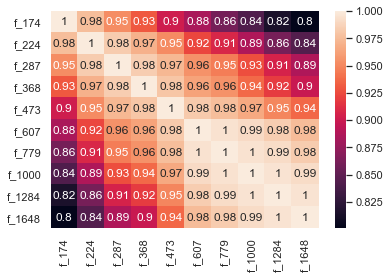

In [13]:
sns.heatmap(X.corr(), annot=True)

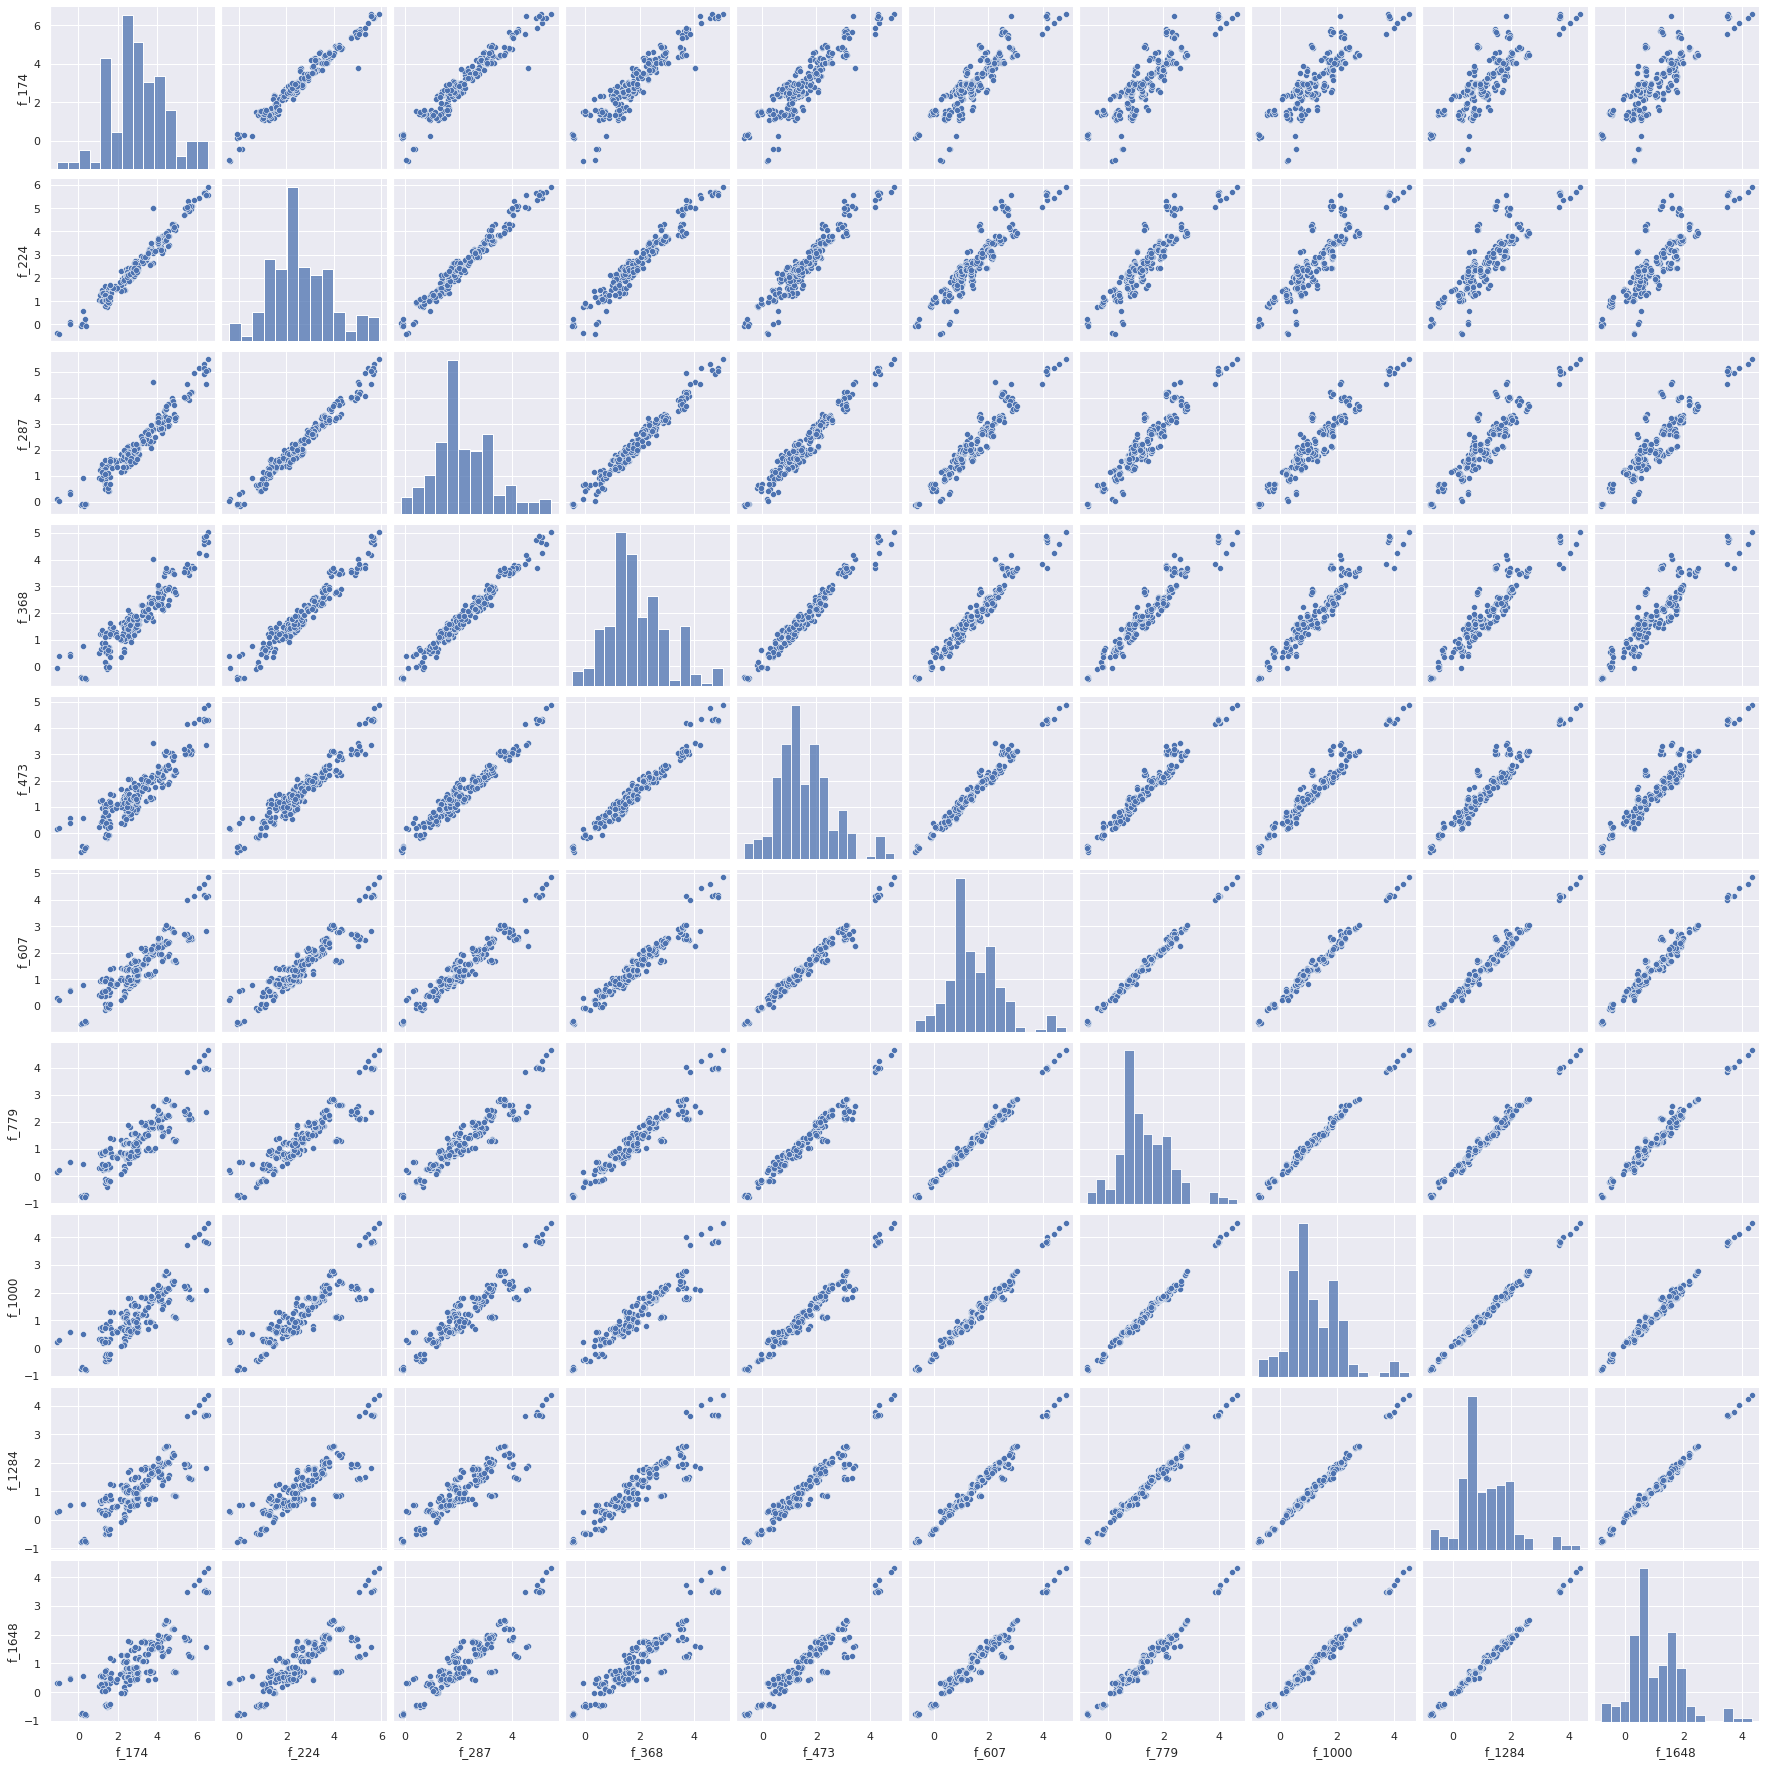

In [16]:
sns.pairplot(X)

# 3. Data Preprocessing

In [17]:
# do feature target transformations
le1 = LabelEncoder()
le2 = LabelEncoder()
scaler = StandardScaler()

X_transformed = scaler.fit_transform(X)
Y_transformed_cell_type = le1.fit_transform(Y['cell_type'])
Y_transformed_time = le2.fit_transform(Y['time'])

# 4. Utility Functions

In [18]:
# conf matrix utility function
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

# 5. Model Algo Functions

In [20]:
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[1.0, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grisearch
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [21]:
def dtree_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(dtree, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [22]:
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC()
    parameters = {'kernel':['poly', 'rbf'],'C':[0.1, 1, 10]}
    scorer = make_scorer(accuracy_score)
    
    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [23]:
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
    
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

# 5. Analysis - Cell Type

In [24]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['cell_type'])
class_names = [c for c in class_names]

The training acc Score is 0.8742857142857143
The testing acc Score is 0.84
The testing acc Score STD 0.04484520748443405
              precision    recall  f1-score   support

         3t3       0.89      0.85      0.87        20
     chondro       0.94      0.94      0.94        18
        hasc       0.89      0.84      0.86        19
        mg63       0.65      0.72      0.68        18

    accuracy                           0.84        75
   macro avg       0.84      0.84      0.84        75
weighted avg       0.85      0.84      0.84        75



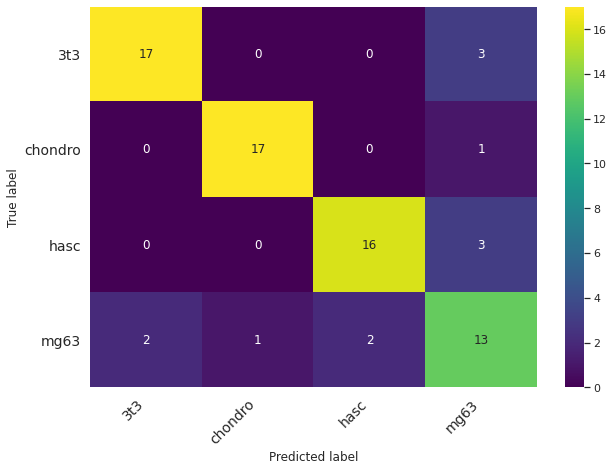

In [25]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9657142857142857
The testing acc Score is 0.88
The testing acc Score STD 0.061352555684533974
              precision    recall  f1-score   support

         3t3       0.90      0.95      0.93        20
     chondro       0.86      1.00      0.92        18
        hasc       0.93      0.74      0.82        19
        mg63       0.83      0.83      0.83        18

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75



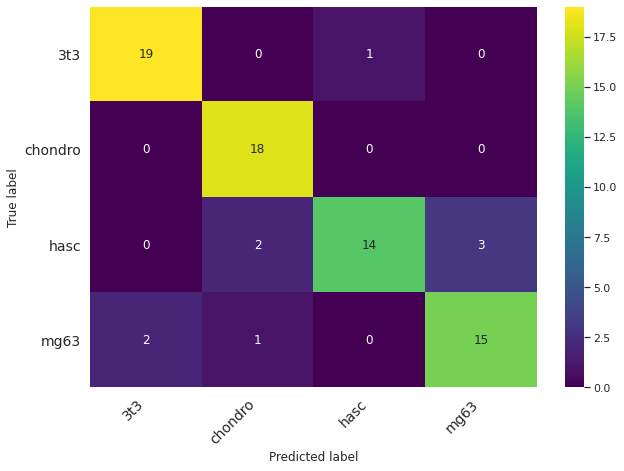

In [26]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9314285714285714
The testing acc Score is 0.92
The testing acc Score STD 0.04502374946456727
              precision    recall  f1-score   support

         3t3       0.95      1.00      0.98        20
     chondro       1.00      1.00      1.00        18
        hasc       0.85      0.89      0.87        19
        mg63       0.88      0.78      0.82        18

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75



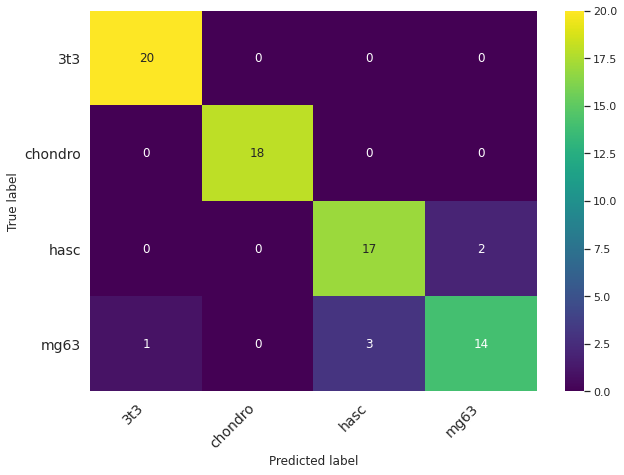

In [27]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 1.0
The testing acc Score is 0.9866666666666667
The testing acc Score STD 0.04799803051448083
              precision    recall  f1-score   support

         3t3       1.00      0.95      0.97        20
     chondro       1.00      1.00      1.00        18
        hasc       0.95      1.00      0.97        19
        mg63       1.00      1.00      1.00        18

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



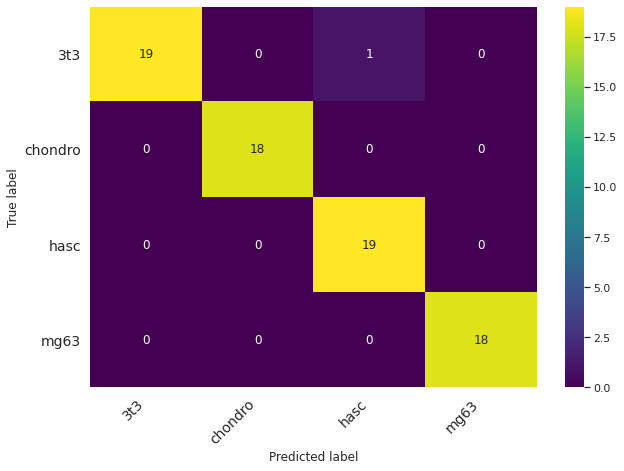

In [28]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 5)

# 6. Analysis - Time

In [29]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['time'])
class_names = [c for c in class_names]

The training acc Score is 0.64
The testing acc Score is 0.5733333333333334
The testing acc Score STD 0.043281984521180726
              precision    recall  f1-score   support

          24       0.60      0.71      0.65        21
          48       0.56      0.54      0.55        26
          96       0.56      0.50      0.53        28

    accuracy                           0.57        75
   macro avg       0.57      0.58      0.58        75
weighted avg       0.57      0.57      0.57        75



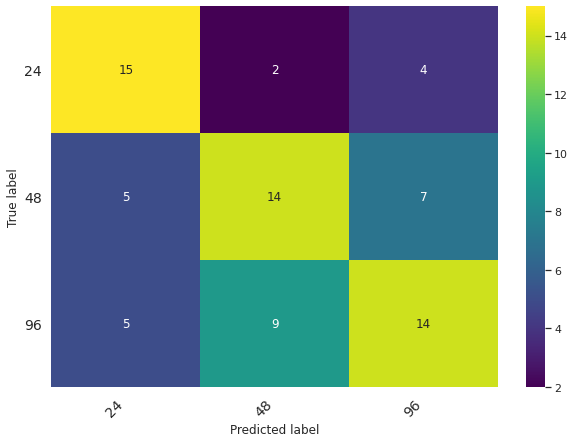

In [30]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.9314285714285714
The testing acc Score is 0.7866666666666666
The testing acc Score STD 0.06130073070026679
              precision    recall  f1-score   support

          24       0.63      0.90      0.75        21
          48       1.00      0.81      0.89        26
          96       0.79      0.68      0.73        28

    accuracy                           0.79        75
   macro avg       0.81      0.80      0.79        75
weighted avg       0.82      0.79      0.79        75



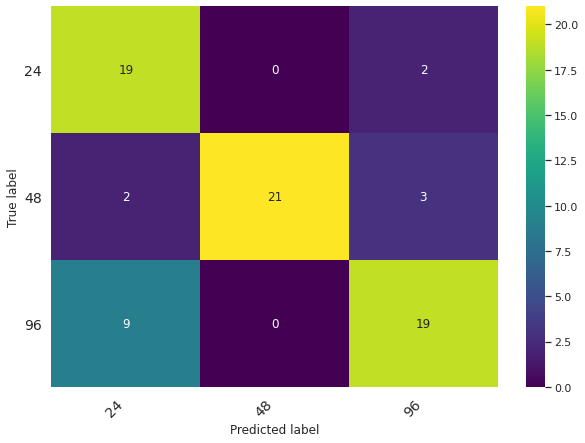

In [31]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 0.8
The testing acc Score is 0.76
The testing acc Score STD 0.04524513729490267
              precision    recall  f1-score   support

          24       0.88      0.67      0.76        21
          48       0.71      0.85      0.77        26
          96       0.75      0.75      0.75        28

    accuracy                           0.76        75
   macro avg       0.78      0.75      0.76        75
weighted avg       0.77      0.76      0.76        75



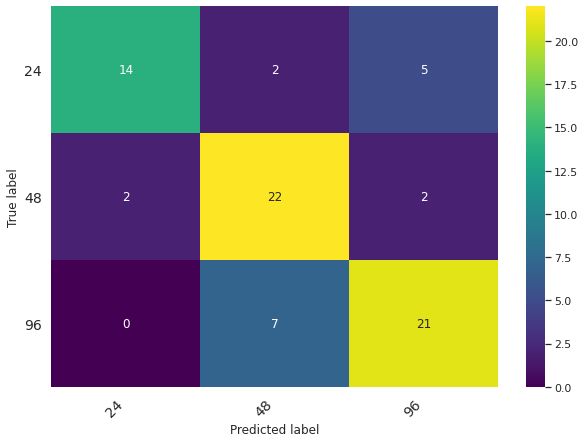

In [32]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 5)

The training acc Score is 1.0
The testing acc Score is 0.96
The testing acc Score STD 0.05316087097546563
              precision    recall  f1-score   support

          24       0.91      1.00      0.95        21
          48       0.96      1.00      0.98        26
          96       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



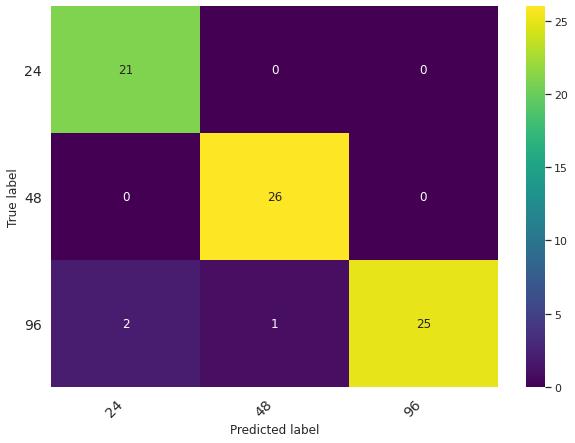

In [33]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 5)

# 7. ANN 

In [51]:
lb1 = LabelBinarizer()
lb2 = LabelBinarizer()

Y_transformed_cell_type_ann = lb1.fit_transform(Y['cell_type'])
Y_transformed_time_ann = lb2.fit_transform(Y['time'])

In [52]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type_ann,
                                                test_size=0.3,
                                                random_state=42)

In [53]:
# good results with celltype
# model = Sequential()
# model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
# model.add(Activation("relu"))
# model.add(Dense(units=8))
# model.add(Activation("relu"))
# model.add(Dense(units=len(lb1.classes_)))
# model.add(Activation("sigmoid"))
# model.summary()

In [54]:
# create the ANN model - cell type
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=8))
model.add(Activation("relu"))
model.add(Dense(units=len(lb1.classes_)))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                176       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
activation_7 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
activation_8 (Activation)    (None, 4)                 0         
Total params: 348
Trainable params: 348
Non-trainable params: 0
________________________________________________________

In [55]:
# create the ANN model for one label - deeper
# model = Sequential()
# model.add(Dense(units=64, input_shape=(X_transformed.shape[1],)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(units=32))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(units=16))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(units=len(lb.classes_)))
# model.add(Activation("softmax"))
# model.summary()

In [56]:
# init some global variables
epochs = 2000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/2000
6/6 [==============================] - 0s 21ms/step - loss: 1.4331 - accuracy: 0.2286 - val_loss: 1.4595 - val_accuracy: 0.1467
Epoch 2/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.4132 - accuracy: 0.2343 - val_loss: 1.4340 - val_accuracy: 0.1467
Epoch 3/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.3950 - accuracy: 0.2400 - val_loss: 1.4107 - val_accuracy: 0.1467
Epoch 4/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.3795 - accuracy: 0.2400 - val_loss: 1.3920 - val_accuracy: 0.1333
Epoch 5/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.3660 - accuracy: 0.2171 - val_loss: 1.3763 - val_accuracy: 0.1467
Epoch 6/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.3537 - accuracy: 0.2286 - val_loss: 1.3633 - val_accuracy: 0.1467
Epoch 7/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.3428 - accuracy: 0.2171 - val_loss: 1.3521 - val_accuracy: 0.1733
Epoch 8/2000
6/6 [=

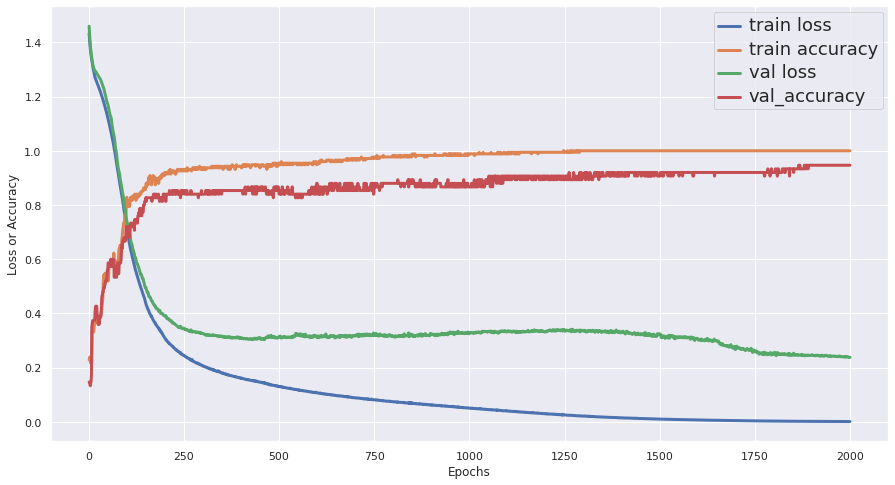

In [57]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [58]:
# calculate the classification report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.90      0.90      0.90        20
           2       0.90      0.95      0.93        20
           3       1.00      1.00      1.00        20

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



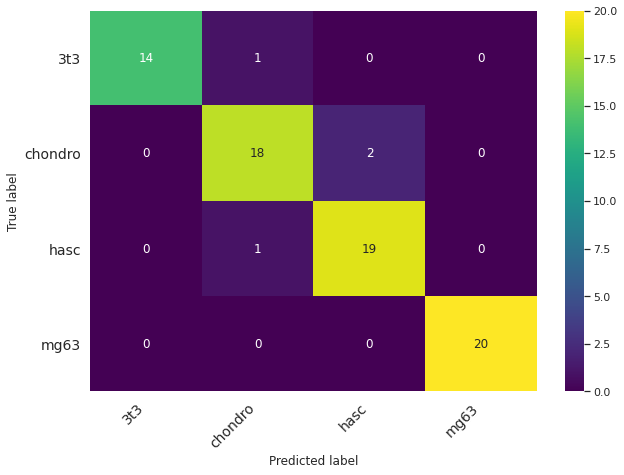

In [59]:
# print confusion matrix

cm = confusion_matrix(testy.argmax(axis=1),
                    preds.argmax(axis=1))
print_confusion_matrix(cm, class_names=le1.classes_)

# ANN for time

In [ ]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time_ann,
                                                test_size=0.3,
                                                random_state=42)

In [ ]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=8))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("sigmoid"))
model.summary()

In [ ]:
# init some global variables
epochs = 500
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

In [ ]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [ ]:
# calculate the classification report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

In [ ]:
# print confusion matrix

cm = confusion_matrix(testy.argmax(axis=1),
                    preds.argmax(axis=1))
print_confusion_matrix(cm, class_names=le1.classes_)

# PCA, TSNE and CV

In [ ]:
####### TSNE
tsne = manifold.TSNE(n_components=2, random_state=42)
tnse_transformed_x = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=np.c_[tnse_transformed_x, Y['cell_type']],
                       columns=['x1', 'x2', 'cell_type'])

In [ ]:
sns.scatterplot(data=tsne_df, x='x1', y='x2', hue='cell_type')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

In [ ]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['cell_type']],
                       columns=['x1','x2', 'cell_type'])
pca_df.head()

In [ ]:
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='cell_type');

In [70]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=8))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                176       
_________________________________________________________________
activation_12 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
activation_13 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 27        
_________________________________________________________________
activation_14 (Activation)   (None, 3)                 0         
Total params: 339
Trainable params: 339
Non-trainable params: 0
________________________________________________________

In [71]:
# init some global variables
epochs = 500
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1107 - accuracy: 0.3257 - val_loss: 1.0970 - val_accuracy: 0.3467
Epoch 2/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0965 - accuracy: 0.3829 - val_loss: 1.0816 - val_accuracy: 0.4400
Epoch 3/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0860 - accuracy: 0.4286 - val_loss: 1.0742 - val_accuracy: 0.4933
Epoch 4/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0795 - accuracy: 0.4343 - val_loss: 1.0690 - val_accuracy: 0.5067
Epoch 5/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0745 - accuracy: 0.4343 - val_loss: 1.0646 - val_accuracy: 0.5067
Epoch 6/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0708 - accuracy: 0.4286 - val_loss: 1.0604 - val_accuracy: 0.5200
Epoch 7/500
6/6 [==============================] - 0s 5ms/step - loss: 1.0666 - accuracy: 0.4343 - val_loss: 1.0565 - val_accuracy: 0.5200
Epoch 8/500
6/6 [=========

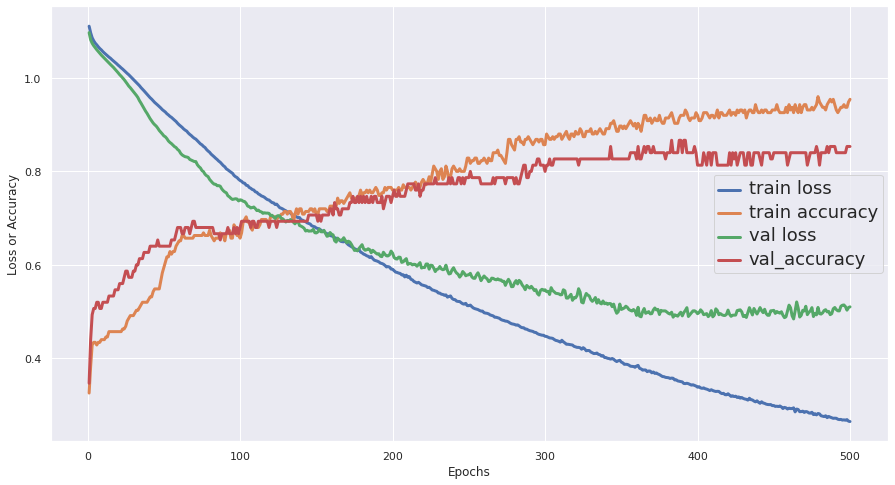

In [72]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [73]:
# calculate the classification report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.84      0.84      0.84        25
           2       0.86      0.80      0.83        30

    accuracy                           0.85        75
   macro avg       0.85      0.86      0.86        75
weighted avg       0.85      0.85      0.85        75



In [74]:
# print confusion matrix

cm = confusion_matrix(testy.argmax(axis=1),
                    preds.argmax(axis=1))
print_confusion_matrix(cm, class_names=le1.classes_)

ValueError: ignored

# PCA, TSNE and CV

In [ ]:
####### TSNE
tsne = manifold.TSNE(n_components=2, random_state=42)
tnse_transformed_x = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=np.c_[tnse_transformed_x, Y['cell_type']],
                       columns=['x1', 'x2', 'cell_type'])

In [ ]:
sns.scatterplot(data=tsne_df, x='x1', y='x2', hue='cell_type')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

In [ ]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['cell_type']],
                       columns=['x1','x2', 'cell_type'])
pca_df.head()

In [ ]:
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='cell_type');